<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Tasks Latencies</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

# Target Configuration

In [3]:
# Setup target configuration
my_conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/media/build/workspace/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : 'baylibre-acme.local',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
        }
    }, 

    # Folder where all the results will be collected
    "results_dir" : "Task_Latencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],

}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

03:49:56  INFO    : Using base path: /media/build/workspace/lisa-github
03:49:56  INFO    : Loading custom (inline) target configuration
03:49:56  INFO    : External tools using:
03:49:56  INFO    :    ANDROID_HOME: /media/build/workspace/android-sdk
03:49:56  INFO    :    CATAPULT_HOME: /media/build/workspace/lisa-github/tools/catapult
03:49:56  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
03:49:56  INFO    : Connecting Android target [0123456789ABCDEF]
03:49:56  INFO    : Connection settings:
03:49:56  INFO    :    {'device': '0123456789ABCDEF'}
03:49:58  INFO    : Initializing target workdir:
03:49:58  INFO    :    /data/local/tmp/devlib-target
03:50:06  INFO    : Attempting to read energy model from target
03:50:13  INFO    : Topology:
03:50:13  INFO    :    [[0, 1, 2, 3], [4, 5, 6, 7]]
03:50:13  INFO    : Loading default EM:
03:50:13  INFO    :    /media/build/workspace/lisa-github/libs/utils/platforms/hikey960.json
03:50:14  INFO    : Enabled tracepoints:
03:50:

# Workload Execution

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

03:50:21  INFO    : Setup new workload ramp
03:50:21  INFO    : Workload duration defined by longest task
03:50:21  INFO    : Default policy: SCHED_OTHER
03:50:21  INFO    : ------------------------
03:50:21  INFO    : task [ramp], sched: using default policy
03:50:21  INFO    :  | loops count: 1
03:50:21  INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
03:50:21  INFO    : |  period   100000 [us], duty_cycle  60 %
03:50:21  INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
03:50:21  INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
03:50:21  INFO    : |  period   100000 [us], duty_cycle  55 %
03:50:21  INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
03:50:21  INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
03:50:21  INFO    : |  period   100000 [us], duty_cycle  50 %
03:50:21  INFO    : |  run_time  50000 [us], sleep_time  50000 [us]
03:50:21  INFO    : + phase_000004: duration 0.500000 [s] (5 loops)
03:50:21  INFO    : |  period   100000 [

# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

03:50:35  INFO    : Content of the output folder /media/build/workspace/lisa-github/results/Task_Latencies


/media/build/workspace/lisa-github/results/Task_Latencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp_1-2.log
├── rt-app-ramp_2-3.log
└── trace.dat

0 directories, 7 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

03:50:37  INFO    : LITTLE cluster max capacity: 402


In [9]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

# Trace visualization

In [10]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency DataFrames

In [11]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

03:52:47  INFO    : Parsing sched_switch states assuming kernel v4.4
03:52:47  INFO    : Parsing sched_switch states assuming kernel v4.4
03:52:47  INFO    : Parsing sched_switch states assuming kernel v4.4
03:52:47  INFO    : Parsing sched_switch states assuming kernel v4.4


,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.837992,NaN,4.0,A,R+,0.837992,0.000263
0.838255,NaN,4.0,R+,A,0.838255,0.000244
0.838499,NaN,4.0,A,R+,0.838499,0.000293
0.838792,NaN,4.0,R+,A,0.838792,0.000237
0.839029,NaN,4.0,A,R,0.839029,0.016267


In [20]:
trace.data_frame.latency_df('ramp')

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.837992,NaN,4.0,A,R+,0.837992,0.000263
0.838255,NaN,4.0,R+,A,0.838255,0.000244
0.838499,NaN,4.0,A,R+,0.838499,0.000293
0.838792,NaN,4.0,R+,A,0.838792,0.000237
0.839029,NaN,4.0,A,R,0.839029,0.016267
0.855296,NaN,4.0,R,A,0.855296,0.000346
0.855642,NaN,4.0,A,R,0.855642,0.019541
0.875183,NaN,4.0,R,A,0.875183,0.000150
0.875333,NaN,4.0,A,R,0.875333,0.007817


In [12]:
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000069,<idle>,1,5,0,shell srvc 1663,16638,120,swapper/1,0,120,2048
0.000725,<...>,1,13,16638,swapper/1,0,120,shell srvc 1663,16638,120,1
0.000780,<idle>,2,18,0,adbd,2387,120,swapper/2,0,120,2048
0.001814,<idle>,1,24,0,->transport,14522,120,swapper/1,0,120,2048
0.002101,->transport,1,29,14522,swapper/1,0,120,->transport,14522,120,1


In [13]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
0.938936,0.000012
1.038951,0.000013
1.138939,0.000013
1.238956,0.000016
1.338770,0.000006


In [14]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
0.838255,0.000244
0.838792,0.000237
0.855296,0.000346
0.875183,0.000150
0.883150,0.000035


## Latency Plots

03:54:53  INFO    : Parsing sched_switch states assuming kernel v4.4
03:54:54  INFO    : Parsing sched_switch states assuming kernel v4.4
03:54:54  INFO    : Parsing sched_switch states assuming kernel v4.4
03:54:54  INFO    : Parsing sched_switch states assuming kernel v4.4
03:54:54  INFO    : Found:    45 WAKEUP latencies
03:54:54  INFO    : Found:    48 PREEMPT latencies
03:54:54  INFO    : Total:    93 latency events
03:54:54  INFO    : 93.5 % samples below 1 [ms] threshold
03:54:54  WARNING : Event [sched_overutilized] not found, plot DISABLED!


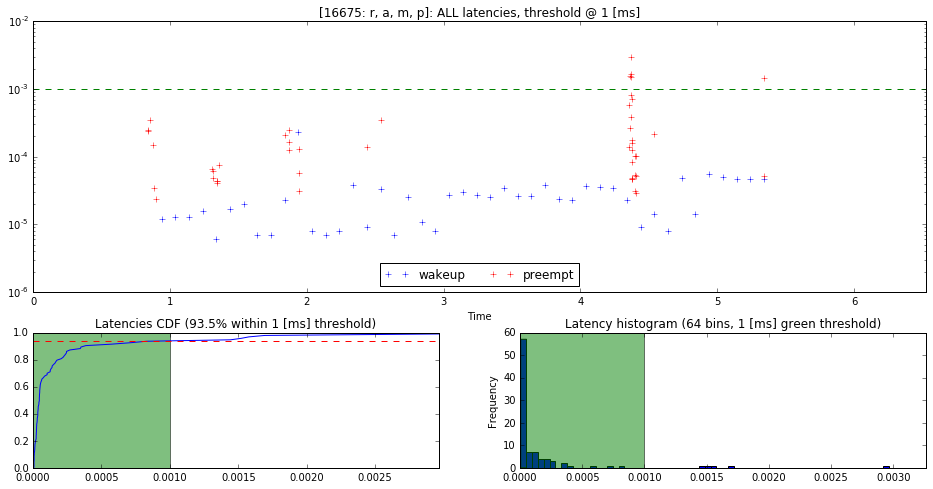

In [15]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [16]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max,93.5%
latency,93.0,0.000189,0.00044,0.000006,0.000046,0.001075,0.001796,0.002966,0.001


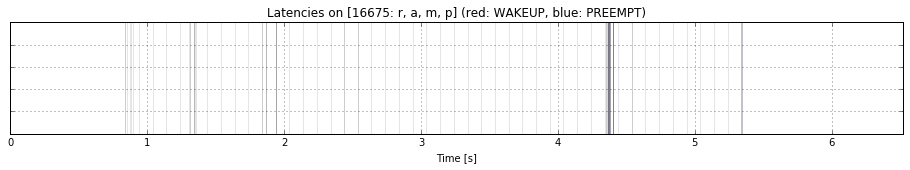

In [17]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

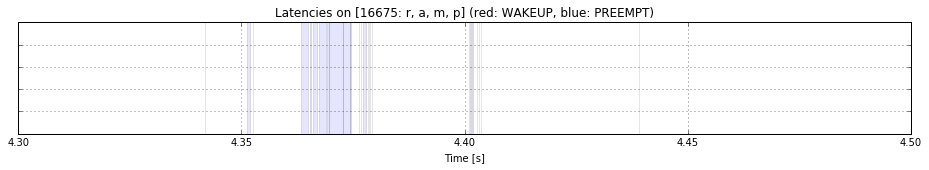

In [19]:
# Zoom into a spefific time frame
#trace.setXTimeRange(3.445, 3.45)
trace.setXTimeRange(4.3, 4.5)
trace.analysis.latency.plotLatencyBands('ramp')